In this notebook, we use the R package "SPARQL" to query the [Nomisma](http://nomisma.org/sparql) sparql endpoint. We pass the endpoint URL to a variable called 'endpoint', and we pass the FULL sparql query to a variable called 'query'.

To run the query, we just run `SPARQL(endpoint,query)`. These results are then passed to a dataframe (which you can think of as the table of the data).

In [94]:
# based on https://www.r-bloggers.com/sparql-with-r-in-less-than-5-minutes/


In [2]:
library(SPARQL) # SPARQL querying package
library(ggplot2)

Loading required package: XML
Loading required package: RCurl
Loading required package: bitops


## Step 1 - Set up preliminaries and define query

In [54]:
# Define the endpoint
endpoint <- "http://nomisma.org/query"

In [85]:
# create query statement
# Here we are retrieving coins of RIC Augustus 1A and 1B
# Do you see where that part is specified?

query <- "PREFIX rdf:		<http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX dcterms:		<http://purl.org/dc/terms/>
PREFIX nm:		<http://nomisma.org/id/>
PREFIX nmo:		<http://nomisma.org/ontology#>
PREFIX foaf:		<http://xmlns.com/foaf/0.1/>
PREFIX skos:	<http://www.w3.org/2004/02/skos/core#>

SELECT ?object ?type ?diameter ?weight ?axis ?type ?collection 
WHERE {
	{?object nmo:hasTypeSeriesItem <http://numismatics.org/ocre/id/ric.1(2).aug.1A> }
	UNION { ?object nmo:hasTypeSeriesItem <http://numismatics.org/ocre/id/ric.1(2).aug.1B> }
	?object rdf:type nmo:NumismaticObject .
	OPTIONAL { ?object nmo:hasWeight ?weight }
	OPTIONAL { ?object nmo:hasDiameter ?diameter }
	OPTIONAL { ?object nmo:hasAxis ?axis }
	OPTIONAL { ?object dcterms:identifier ?identifier }
	OPTIONAL { ?object nmo:hasCollection ?colUri .
		?colUri skos:prefLabel ?collection FILTER(langMatches(lang(?collection), 'EN'))}
	
}"


## Step 2 - Use SPARQL package to submit query and save results to a data frame

In [86]:
qd <- SPARQL(endpoint,query)
df <- qd$results

In [93]:
# check the first few rows to see what we've got
head(df)

object,type,diameter,weight,axis,collection
<http://collection.britishmuseum.org/id/object/CGR219967>,NA,NA,1.51,2,"""British Museum""@en"
<http://collection.britishmuseum.org/id/object/CGR219966>,NA,NA,1.71,8,"""British Museum""@en"
<http://collection.britishmuseum.org/id/object/CGR90067>,NA,NA,1.55,4,"""British Museum""@en"
<http://collection.britishmuseum.org/id/object/CGR90066>,NA,NA,1.81,7,"""British Museum""@en"
<http://data.fitzmuseum.cam.ac.uk/id/object/103909>,NA,NA,1.55,12,"""Fitzwilliam Museum""@en"
<http://numismatics.org/collection/1944.100.39025>,NA,14.5,1.75,2,"""American Numismatic Society""@en"


## Step 3 - Fix data class if necessary

In [88]:
# Numbers are sometimes returned as characters
#check to see if a column is character (chr) or numeric
str(df)

'data.frame':	28 obs. of  6 variables:
 $ object    : chr  "<http://collection.britishmuseum.org/id/object/CGR219967>" "<http://collection.britishmuseum.org/id/object/CGR219966>" "<http://collection.britishmuseum.org/id/object/CGR90067>" "<http://collection.britishmuseum.org/id/object/CGR90066>" ...
 $ type      : logi  NA NA NA NA NA NA ...
 $ diameter  : num  NA NA NA NA NA 14.5 13.5 13.5 14.5 14 ...
 $ weight    : num  1.51 1.71 1.55 1.81 1.55 1.75 1.63 1.48 1.73 1.66 ...
 $ axis      : int  2 8 4 7 12 2 9 5 5 2 ...
 $ collection: chr  "\"British Museum\"@en" "\"British Museum\"@en" "\"British Museum\"@en" "\"British Museum\"@en" ...


In [82]:
# if any of the columns were coded as characters, but we needed them as numeric, we
# could select the relevant column with the $ and convert it like so:
# eg, if 'weight' was chr, we select the weight column and we copy it, turn it into numeric, and paste it back in place

#df$weight <- as.numeric(as.character(df$weight))
#str(df)

## Step 4 See what we've got

In [89]:
# so now we could do some statistics. Incidentally, there were empty cells that now have <NA> in them; we need to ignore them when we calculate the mean
mean(df$weight, na.rm = TRUE)
mean(df$axis, na.rm = TRUE)
mean(df$diameter, na.rm = TRUE)

[1] 1.656393

[1] 7.285714

[1] 13.75563

In [90]:
# how many examples do we have from each collection, with how many at what diameter?
summary_table <- table(df$collection, df$diameter)
summary_table

                                             
                                              12 13 13.09 13.5 14 14.5 15
  "American Numismatic Society"@en             0  0     0    2  1    4  1
  "British Museum"@en                          0  0     0    0  0    0  0
  "Fitzwilliam Museum"@en                      0  0     0    0  0    0  0
  "Münzkabinett Berlin"@en                     1  3     0    0  3    0  0
  "Münzkabinett der Universität Göttingen"@en  0  0     1    0  0    0  0
  "University of Graz"@en                      0  0     0    0  0    0  0

# Step 5 - Visualize some aspects of the data

`geom_smooth()` using method = 'loess'


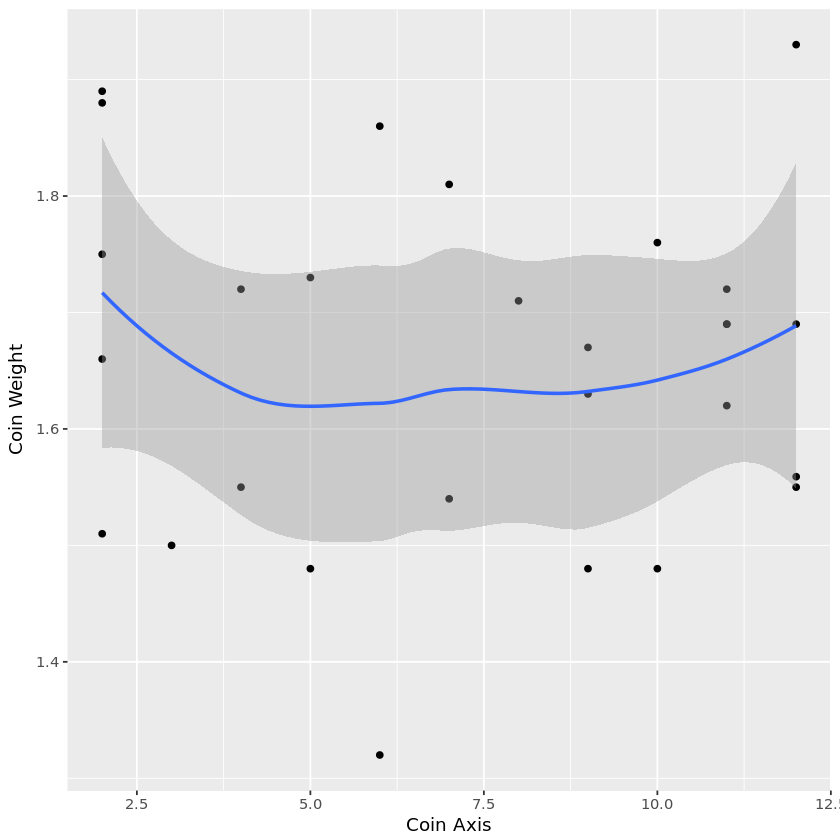

In [91]:
# Let's imagine that it is meaningful to compare the weight of the coins against the axis
ggplot(df, aes(x=df$axis, y=df$weight)) +
geom_point() +
stat_smooth() +
xlab("Coin Axis") +
ylab("Coin Weight")